**adaBoost**

Евгений Борисов borisov.e@solarl.ru

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

---

In [2]:
# # загружаем даные
# data = [ np.vstack([
#             np.loadtxt('../data/399_4/points_b.txt'),
#             np.loadtxt('../data/399_4/points_g.txt'),
#             np.loadtxt('../data/399_4/points_r.txt')
#         ]),
#         np.loadtxt('../data/399_4/points_y.txt') 
# ]

In [3]:
# загружаем даные
data = [
    np.loadtxt('../data/6402_2/points_1.txt'),
    np.loadtxt('../data/6402_2/points_2.txt') 
]

In [4]:
# собираем вместе
X = np.vstack(data)

# метки классов
# [-1,1] для выходной активации sigmoid
y = [ [i]*data[i].shape[0] for i in range(len(data)) ]
y = np.asarray(sum(y,[])) # .reshape([-1,1])
# y = OneHotEncoder(sparse=False,categories='auto').fit_transform(y)
y = y*2-1
X.shape, y.shape

((6402, 2), (6402,))

In [5]:
# нормируем данные
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=512)
y_train.shape[0], y_test.shape[0]

(3201, 3201)

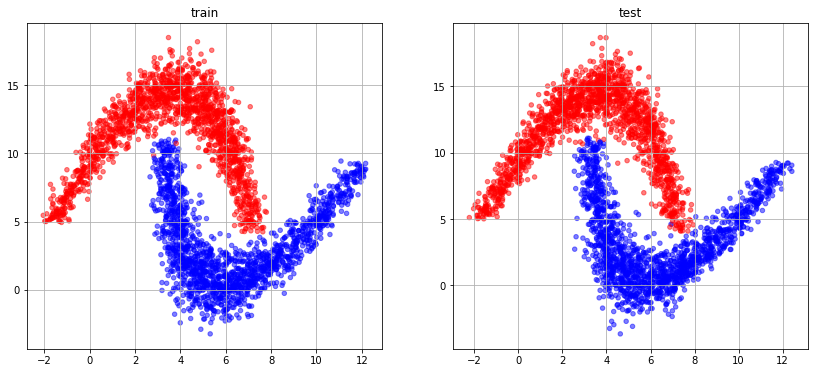

In [7]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('train')
axarr[i].scatter( x=X_train[:,0], 
             y=X_train[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_train ], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

i+=1
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_test], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

plt.show()

In [8]:
%xdel data
%xdel X
%xdel y

---

In [9]:
# набор пороговых классификаторов h(номер признака, порог)
# веса классификаторов

In [10]:
# idx = [0]
# bound = [2]

In [11]:
# пороговый классификатор
#    вход, номер признака, порог, знак классификатора [-1,1]
def h(X,i,b,s): return s*np.sign(X[:,i]-b)

# ошибка классификатора h 
def err_count(X,i,b,s,w,y): return ((h(X,i,b,s)!=y).astype(int)*w).sum()

# разделение набора с наименьшей ошибкой
def search_split(X,w,s,y,nb=30):
    # список порогов для каждого признака
    b = np.vstack([ np.linspace( X[:,i].min(), X[:,i].max(), nb )[1:-1] 
                    for i in range(X.shape[1]) ])
    
    # количество ошибок для разных признаков и значений порогов 
    err = np.array([ 
        [ err_count(X,i,b[i,j],s,w,y) for i in range(X.shape[1]) ]     
        for j in range(b.shape[1]) 
    ])
    # параметры с минимальным значением ошибок
    j,i = np.unravel_index(err.argmin(),err.shape)

    return i,b[i,j],err[j,i]

In [12]:
#w = np.ones(X_train.shape[0])/X_train.shape[0]
#search_split(X_train,w,1,y_train)

In [13]:
#search_split(X_train,w,-1,y_train)

In [14]:
# веса объектов учебной выборки
w = np.ones(X_train.shape[0])/X_train.shape[0]
r=[]

for i in range(20):
    i0,b0,err0 = search_split(X_train,w,1,y_train)
    i1,b1,err1 = search_split(X_train,w,-1,y_train)
    
    # print(err0,err1)
    
    i,b,err,s = (i0,b0,err0,1) if (err0<err1) else (i1,b1,err1,-1)
    
    # i,b,err = search_split(X_train,w,y_train)
    
    a = 0.5*np.log((1.0-err)/err)
    
    r.append([a,i,b,s,err])

    w = w*np.exp( -a*y_train*h(X_train,i,b,s) )
    w = w/w.sum()
    
# r = np.asarray(r)

0.30834114339268975 0.13058419243986255
0.29255158197325876 0.3135484237002856
0.2634300054265173 0.23224328609696662
0.32860520256559195 0.25874937929820263
0.27229385397738104 0.34222219591382086
0.32021235217149513 0.2817711996258946
0.27654686293579134 0.34159417054743313
0.27686342630205585 0.2980653733120674
0.3457161608097913 0.30683239848184296
0.3641778713473146 0.31358135435212714
0.31371890758784493 0.28285221593431065
0.2673506153138838 0.35032860085235074
0.2911221544778316 0.3015036153518057
0.3526700708439362 0.3299468771122033
0.37133975806314556 0.3144870826659775
0.32466940611189854 0.2931059396191754
0.30994931769365935 0.3625549372276117
0.29490741636542644 0.31308602020043486
0.3545633662905846 0.32450736065949926
0.3701002578563712 0.3212635151328143


In [15]:
# r

In [16]:
def run(X,r): return np.sign(np.sum([ a*h(X,i,b,s) for a,i,b,s,_ in r ],axis=0)) 

o = run(X_test,r)

(o!=y_test).sum()/y_test.shape[0]


# err_count(X_train[:,i],b,y_train)/len(y_train)
# at=log((1-er)/er)*0.5; 
# пересчитываем вероятности ошибок на примерах
# Yr = si*bound(X,b,n);
# P=P.*exp(-at*(Yr.*Y)); 
# P=P/sum(P);% нормируем вероятности ошибок

#i,b

0.00718525460793502

In [17]:
# from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=1)
# clf.fit(X_train,y_train) 
# o = clf.predict(X_test)
# (y_test!=o).sum()

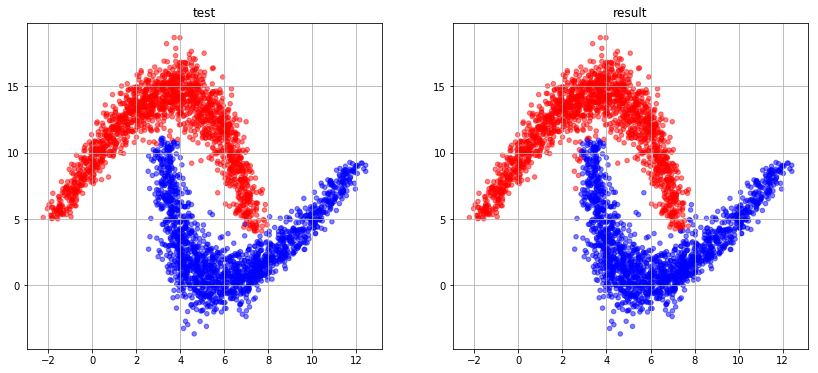

In [18]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_test], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

i+=1
axarr[i].set_title('result')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in o], 
             s=20,
             alpha=0.5 )
axarr[i].grid()



plt.show()